# Ch 4a: Design Patterns 11 and 12

Design Pattern 11: Useful Overfitting

Design Pattern 12: Checkpoints 

# Design Pattern 11: Useful Overfitting

Situations where overfitting is beneficial. Here its used to gut check ML model.

In [69]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model
%matplotlib inline

In [70]:
df = pd.read_csv('data/babyweight_train.csv')

In [71]:
# Prepare inputs
df['is_male'] = df['is_male'].astype(str)
df['mother_race'] = df['mother_race'].fillna(0)
df['mother_race'] = df['mother_race'].astype(str)

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']
LABEL = ['weight_pounds']

N_TRAIN = int(df.shape[0] * 0.80)

X_train = df[FEATURES][:N_TRAIN]
X_valid = df[FEATURES][N_TRAIN:]

y_train = df[LABEL][:N_TRAIN]
y_valid = df[LABEL][N_TRAIN:]

In [72]:
# prepare inputs
df.is_male = df.is_male.astype(str)

df.mother_race.fillna(0, inplace = True)
df.mother_race = df.mother_race.astype(str)

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']
LABEL = ['weight_pounds']

N_TRAIN = int(df.shape[0] * 0.80)

X_train = df[FEATURES][:N_TRAIN]
X_valid = df[FEATURES][N_TRAIN:]


y_train = df[LABEL][:N_TRAIN]
y_valid = df[LABEL][N_TRAIN:]

In [73]:
# Create input pipeline
trainds = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train.values))
evalds = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid.values))

# Examine datasets
for dict_slice in trainds.take(1):
  print(f"{dict_slice}\n")

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([7.74924851])>)



In [74]:
# Setup feature columns
## Feature column for categorical variables
numeric_columns = [
  fc.numeric_column("mother_age"),
  fc.numeric_column("gestation_weeks")
]

CATEGORIES = {
  'plurality': list(df['plurality'].unique()),
  'is_male': list(df['is_male'].unique()),
  'mother_race': list(df['mother_race'].unique()),
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
  cat_col = fc.categorical_column_with_vocabulary_list(
    key=feature,
    vocabulary_list=vocab,
    dtype=tf.string
  )
  categorical_columns.append(fc.indicator_column(cat_col))

In [75]:
# Build simple neural network
inputs = {
  colname: tf.keras.layers.Input(
    name=colname,
    shape=(),
    dtype='float32'
  ) for colname in ['mother_age', 'gestation_weeks']
}
inputs.update({
  colname: tf.keras.layers.Input(
    name=colname,
    shape=(),
    dtype=tf.string
  ) for colname in ['plurality', 'is_male', 'mother_race']
})

# build DenseFeatures for model
dnn_inputs = layers.DenseFeatures(categorical_columns + numeric_columns)(inputs)

# create hidden layers
h1 = layers.Dense(20, activation='relu')(dnn_inputs)
h2 = layers.Dense(10, activation='relu')(h1)

# create model
output = layers.Dense(1, activation='relu')(h2)
model = tf.keras.models.Model(inputs=inputs, outputs=output)
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.MeanSquaredError(),
  metrics=['mse']
)

## Overfit on a batch


Inspect train data pipeline by pulling a single batch of 5 examples

In [76]:
for feature_batch, label_batch in trainds.batch(5).take(1):
  print(f"'babyweigth': {label_batch}")
  print("'features:")
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'babyweigth': [[7.74924851]
 [7.56185559]
 [7.18706974]
 [6.37576862]
 [7.93664143]]
'features:
  'is_male'           : [b'False' b'True' b'False' b'True' b'False']
  'mother_age'        : [12 12 12 12 12]
  'plurality'         : [b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)']
  'gestation_weeks'   : [40 40 34 36 35]
  'mother_race'       : [b'1.0' b'2.0' b'3.0' b'2.0' b'0.0']


In [77]:
BATCH_SIZE = 256
single_batch = trainds.batch(BATCH_SIZE).take(1)

Train the model on a single batch. Use the `.repeat()` method to repeatedly call the training data. Number of training examples is the same as the batch size

In [78]:
# train the classification model
tf.random.set_seed(33)

NUM_TRAINING_EXAMPLES = BATCH_SIZE # total number of training examples
NUM_VALID_EXAMPLES = X_valid.shape[0]
NUM_EPOCHS = 100
TOTAL_TRAINING_EXAMPLES = int(NUM_EPOCHS * NUM_TRAINING_EXAMPLES)

steps_per_epoch = (TOTAL_TRAINING_EXAMPLES // (BATCH_SIZE * NUM_EPOCHS))

evalds = evalds.batch(X_valid.shape[0]).take(int(NUM_VALID_EXAMPLES // BATCH_SIZE))

# train the model
history = model.fit(
  single_batch.repeat(),
  validation_data=evalds,
  epochs=NUM_EPOCHS,
  steps_per_epoch=steps_per_epoch,
  verbose=1
)

Epoch 1/100
1/1 [==============================] - 1s 781ms/step - loss: 20.6875 - mse: 20.6875 - val_loss: 77.3651 - val_mse: 77.3651
Epoch 2/100
1/1 [==============================] - 0s 179ms/step - loss: 17.5215 - mse: 17.5215 - val_loss: 68.4100 - val_mse: 68.4100
Epoch 3/100
1/1 [==============================] - 0s 214ms/step - loss: 14.6521 - mse: 14.6521 - val_loss: 60.0677 - val_mse: 60.0677
Epoch 4/100
1/1 [==============================] - 0s 205ms/step - loss: 12.0775 - mse: 12.0775 - val_loss: 52.3052 - val_mse: 52.3052
Epoch 5/100
1/1 [==============================] - 0s 177ms/step - loss: 9.7990 - mse: 9.7990 - val_loss: 45.1319 - val_mse: 45.1319
Epoch 6/100
1/1 [==============================] - 0s 221ms/step - loss: 7.8158 - mse: 7.8158 - val_loss: 38.5741 - val_mse: 38.5741
Epoch 7/100
1/1 [==============================] - 0s 177ms/step - loss: 6.1231 - mse: 6.1231 - val_loss: 32.6340 - val_mse: 32.6340
Epoch 8/100
1/1 [==============================] - 0s 182ms/s

In [79]:
def plot_curves(history, metrics):
  nrows = 1
  ncols = 2
  fig = plt.figure(figsize=(10, 5))

  for idx, key in enumerate(metrics):  
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

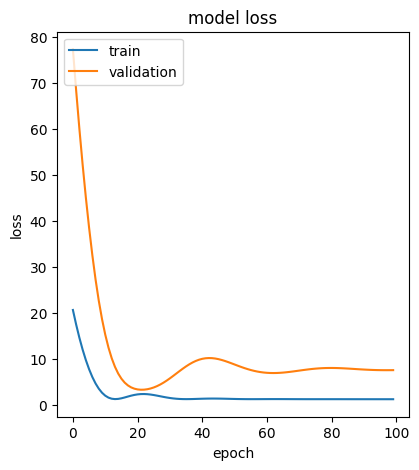

In [80]:
plot_curves(history, ['loss'])

# Design Pattern 12: Checkpoints

Store the state of the model periodically so that partially trained models are always available. They serve as starting points for continued training (e.g if the training step failes or for further fine-tuning)

In [1]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import os

load_dotenv(dotenv_path=Path("../.env"))

True

In [2]:
%load_ext google.cloud.bigquery
from google.cloud import bigquery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = f"../{os.environ.get('GCP_KEY_FILE')}"
bq = bigquery.Client()

Create the dataset from BigQuery. Consists of 19M rows

In [ ]:
import tensorflow as tf
from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession

def features_and_labels(features):
  label = features.pop('tolls_amount') # this is what we will train for
  return features, tf.cast(label > 0, dtypes.int64, name='threshold')

def read_dataset(client, row_restriction, batch_size=2048, infinite=True):
    GCP_PROJECT_ID='ai-analytics-solutions'  # CHANGE
    COL_NAMES = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'tolls_amount']
    COL_TYPES = [dtypes.float64] * len(COL_NAMES)
    DATASET_GCP_PROJECT_ID, DATASET_ID, TABLE_ID,  = 'bigquery-public-data.new_york.tlc_green_trips_2015'.split('.')
    bqsession = client.read_session(
        "projects/" + GCP_PROJECT_ID,
        DATASET_GCP_PROJECT_ID, TABLE_ID, DATASET_ID,
        COL_NAMES, COL_TYPES,
        requested_streams=2,
        row_restriction=row_restriction + ' AND pickup_longitude > -80 AND dropoff_longitude < -70')
    dataset = bqsession.parallel_read_rows()
    dataset = dataset.prefetch(1).map(features_and_labels).shuffle(batch_size*10).batch(batch_size)
    if infinite:
        dataset = dataset.repeat()
    return dataset

client = BigQueryClient()

In [ ]:
temp_df = read_dataset(client, "pickup_datetime BETWEEN '2015-01-01' AND '2015-03-31'")
for row in temp_df:
  print(row)
  break

In [ ]:
BATCH_SIZE = 2048
train_df = read_dataset(client, "pickup_datetime BETWEEN '2015-01-01' AND '2015-03-31'", BATCH_SIZE)
eval_df = read_dataset(client, "pickup_datetime BETWEEN '2015-04-01' AND '2015-04-30'", BATCH_SIZE, infinite=False) # for validation, read it only once

Create model

In [ ]:
metrics = [
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc')
]

inputs = {
  colname: tf.keras.layers.Input(name=colname, shape=(), dtype='float64')
  for colname in ['pikcup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
}
input_fc = [tf.feature_column.numeric_column(colname) for colname in inputs.keys()]

# transformations, passthrough
transformed = inputs.copy()
input_layer = tf.keras.layers.DenseFeatures(input_fc, name='features')(transformed)

# create model
d1 = tf.keras.layers.Dense(16, activation='relu', name='d1')(input_layer)
d1 = tf.keras.layers.Dropout(0.25, name='d2')(d1)
d1 = tf.keras.layers.Dense(17, activation='relu', name='d3')(d2)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='d4', bias_initializer=tf.keras.initializer.Constant())(d3)

model = tf.keras.Model(inputs, output)
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=metrics
)
tf.keras.utils.plot_model(model, rankdir='LR')

In [ ]:
class_weight = {0: 0.5, 1: 25.0}

OUTDIR = 'trained'
import shutil
shutil.rmtree(OUTDIR, ignore_errors=True)

NUM_TRAINING_EXAMPLES = 1000 * 1000 * 5
STOP_POINT = 3.5
TOTAL_TRAINING_EXAMPLES = int(STOP_POINT * NUM_TRAINING_EXAMPLES)
NUM_CHECKPOINTS = 10
steps_per_epoch = (
  TOTAL_TRAINING_EXAMPLES // (BATCH_SIZE * NUM_CHECKPOINTS)
)
checkpoint_path = f"{OUTDIR}/checkpoints/taxi"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=False
                                                 verbose=1)
history = model.fit(
  train_df,
  validation_data=eval_df,
  epochs=NUM_CHECKPOINTS,
  steps_per_epoch=steps_per_epoch,
  class_weight=class_weight
)                                                

In [ ]:
class_weight = {0: 0.5, 1: 25.0}

OUTDIR = 'trained'
import shutil
shutil.rmtree(OUTDIR, ignore_errors=True)

NUM_TRAINING_EXAMPLES = 1000 * 1000 * 5
STOP_POINT = 3.5
TOTAL_TRAINING_EXAMPLES = int(STOP_POINT * NUM_TRAINING_EXAMPLES)
NUM_CHECKPOINTS = 10
steps_per_epoch = (TOTAL_TRAINING_EXAMPLES // (BATCH_SIZE * NUM_CHECKPOINTS))

checkpoint_path = '{}/checkpoints/taxi'.format(OUTDIR)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)
history = model.fit(
  train_df,
  validation_data=eval_df,
  epochs=NUM_CHECKPOINTS,
  steps_per_epoch=steps_per_epoch,
  class_weight=class_weight
)                                                 